In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 1. EDA

In [3]:
# Load Data
op = 0 # 0: Local, 1: Kaggle

if not op: # Local
    train_path = './data/train.csv'
    test_path = './data/test.csv'
    sub_path = './data/gender_submission.csv'
    save_path = './data/submission.csv'
else:  # Kaggle
    train_path = '/kaggle/input/titanic/train.csv'
    test_path = '/kaggle/input/titanic/test.csv'
    sub_path = '/kaggle/input/titanic/gender_submission.csv'    
    save_path = '/kaggle/working/submission.csv'
    

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_sub = pd.read_csv(sub_path)


# Check NaN
train_null = df_train[df_test.columns].isnull().sum()
test_null = df_test[df_test.columns].isnull().sum()

df_null_check = pd.DataFrame({
    'Column': df_test.columns,
    'Train_Null': train_null.values,
    'Test_Null': test_null.values
})

print(df_null_check)

         Column  Train_Null  Test_Null
0   PassengerId           0          0
1        Pclass           0          0
2          Name           0          0
3           Sex           0          0
4           Age         177         86
5         SibSp           0          0
6         Parch           0          0
7        Ticket           0          0
8          Fare           0          1
9         Cabin         687        327
10     Embarked           2          0


In [4]:
# 'Age', 'Cabin', 'Embarked', 'Fare' colums has NaN
# In 'Age','Fare' NaN is mean for Pclass
# In 'Cabin', 'Embarked', NaN is 'N'

# Mean for Pclass
print(df_train.groupby('Pclass')[['Age', 'Fare']].mean())

# 'Cabin' preprocessing
def simplify_cabin(cabin):
    if isinstance(cabin, str) and cabin.strip().isalnum() and len(cabin) > 1:
        if cabin[0].isalpha() and cabin[1:].isdigit():
            return cabin[0]
    return np.nan

df_train['Cabin'] = df_train['Cabin'].apply(simplify_cabin)
df_test['Cabin'] = df_test['Cabin'].apply(simplify_cabin)

# Fill NaN Function
def fill_NaN(df):
    df['Age'] = df['Age'].fillna(df.groupby('Pclass')['Age'].transform('mean'))
    df['Fare'] = df['Fare'].fillna(df.groupby('Pclass')['Fare'].transform('mean'))
    df['Cabin'] = df['Cabin'].fillna('N')
    df['Embarked'] = df['Embarked'].fillna('N')
    return df

df_train = fill_NaN(df_train)
df_test = fill_NaN(df_test)

print("======================")
print(f'train isnull : {df_train.isnull().values.any()}')
print(f'test isnull : {df_test.isnull().values.any()}')
print(f'Cabin unique : {df_train["Cabin"].unique()}')
print(f'Embarked unique : {df_train["Embarked"].unique()}')

              Age       Fare
Pclass                      
1       38.233441  84.154687
2       29.877630  20.662183
3       25.140620  13.675550
train isnull : False
test isnull : False
Cabin unique : ['N' 'C' 'E' 'G' 'D' 'A' 'B' 'F']
Embarked unique : ['S' 'C' 'Q' 'N']


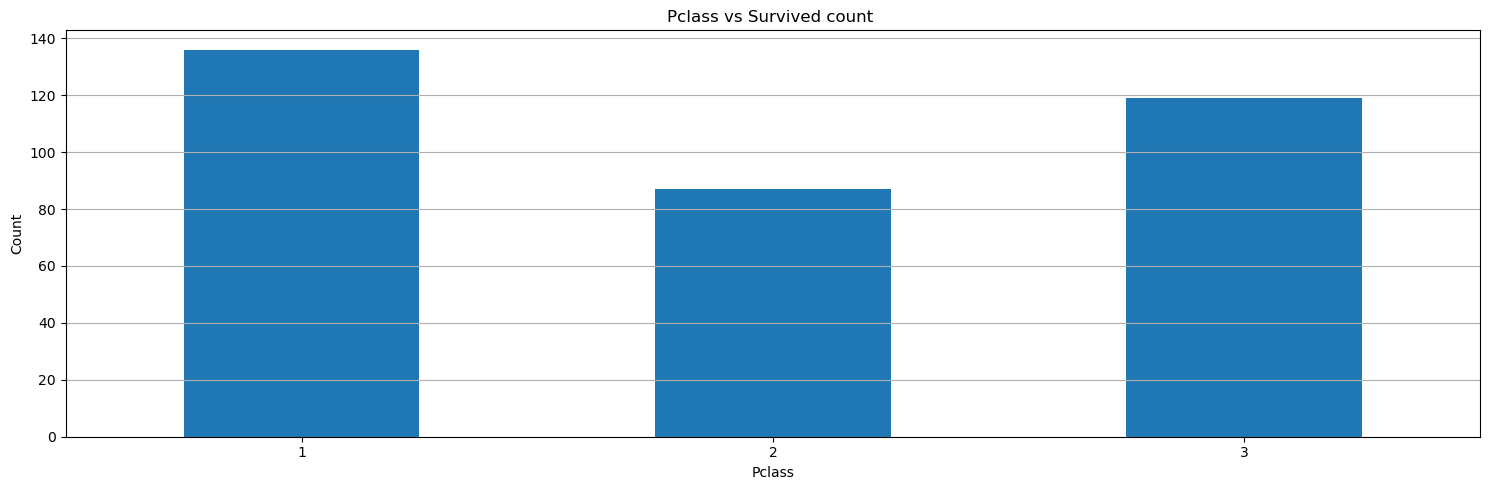

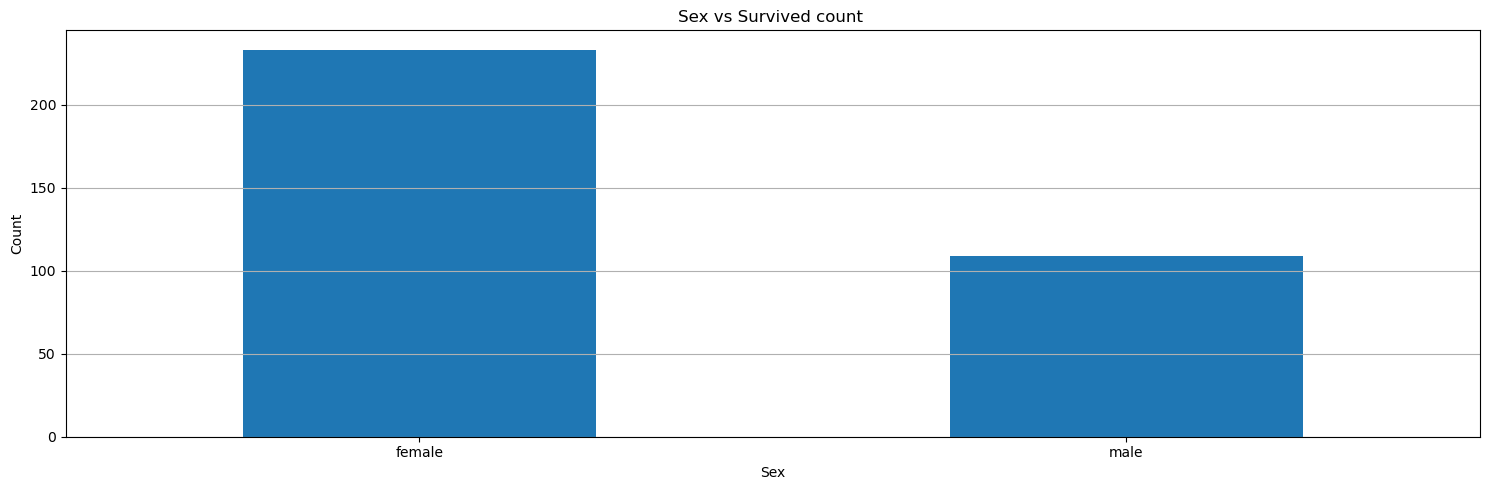

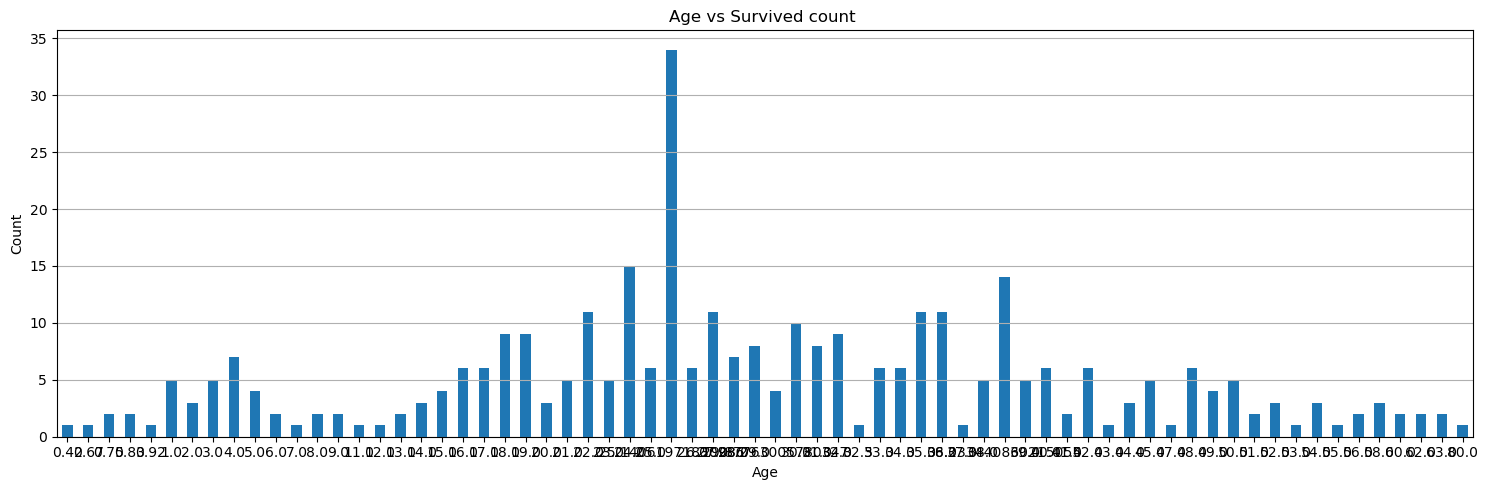

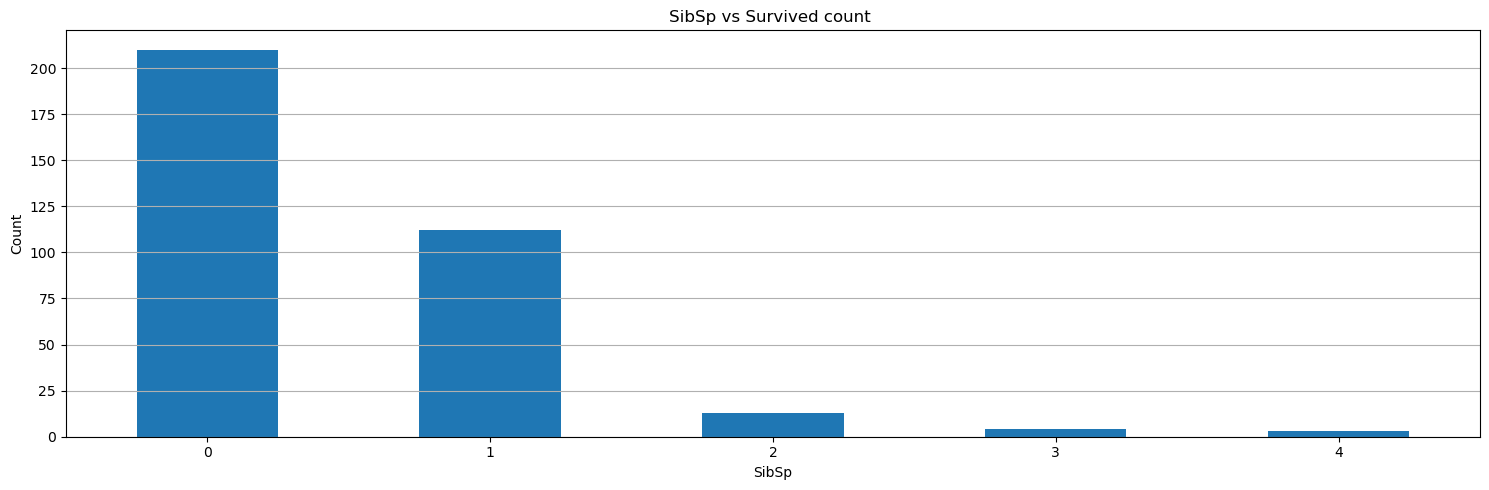

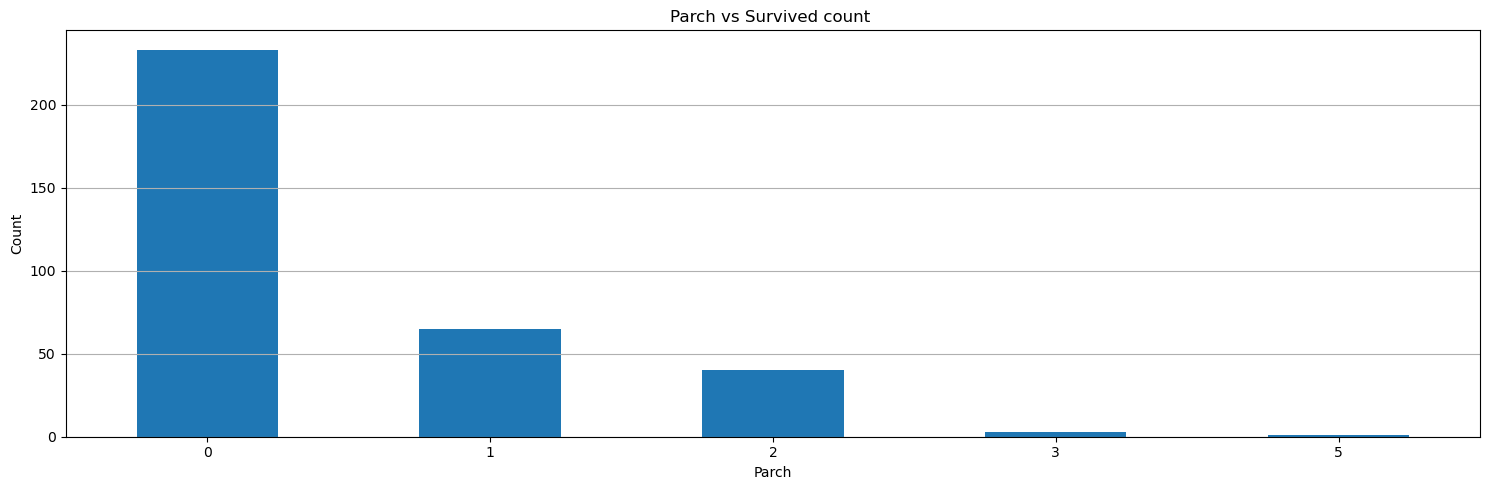

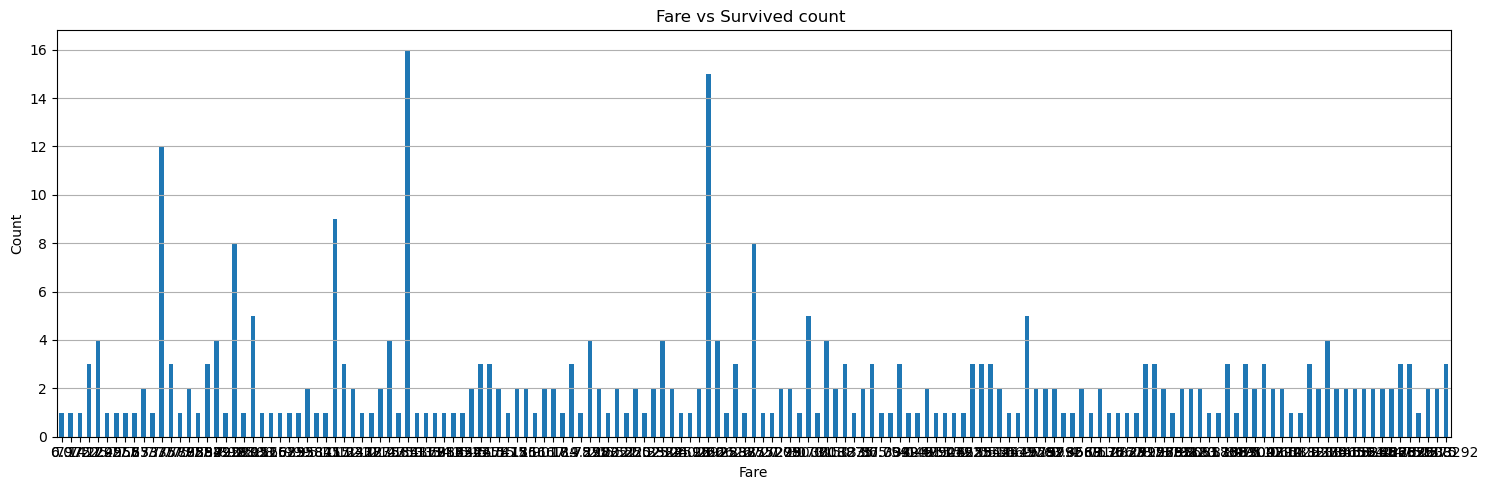

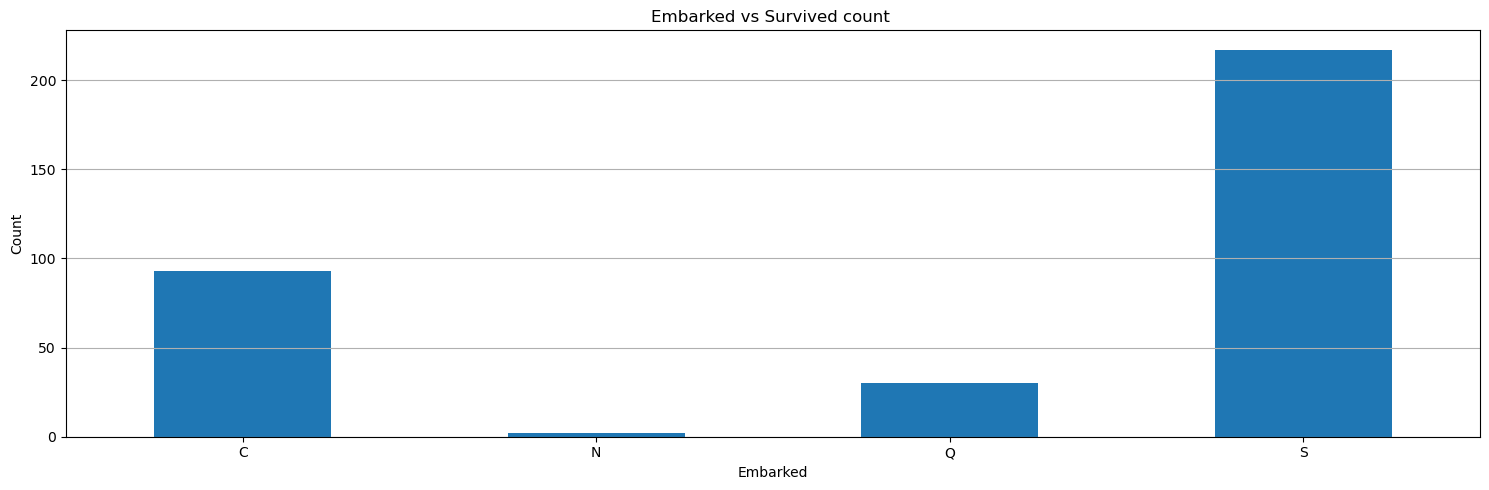

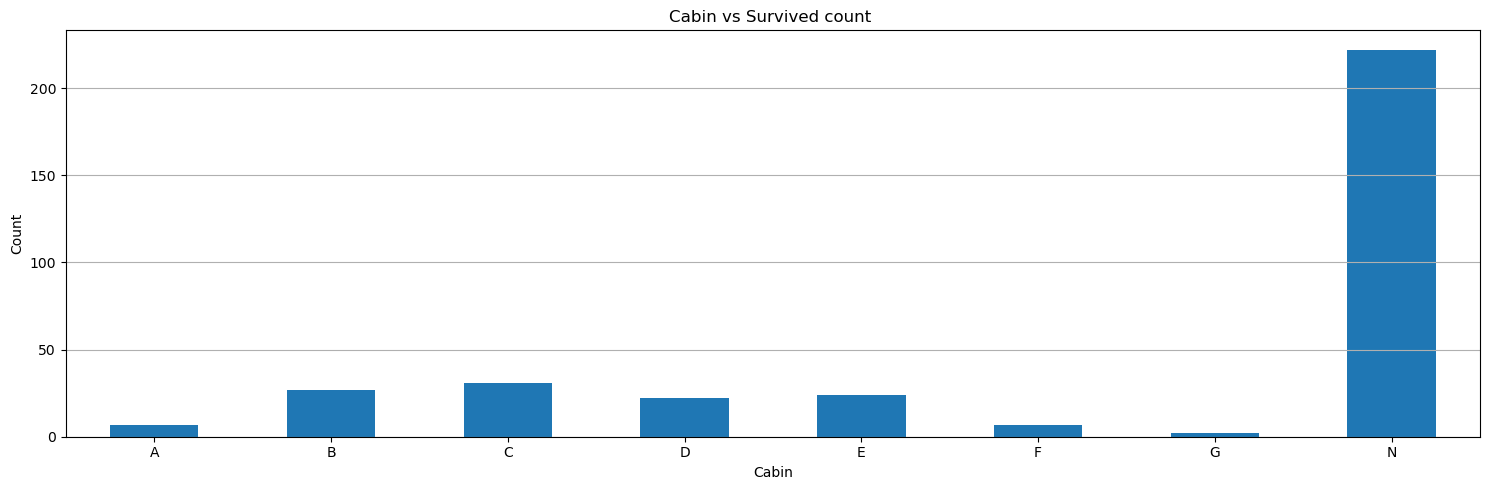

In [6]:
# Check Scatter
target_col = 'Survived'
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']

for col in features:
    survived_counts = df_train[df_train['Survived'] == 1][col].value_counts().sort_index()

    plt.figure(figsize=(15, 5))
    survived_counts.plot(kind='bar')
    plt.title(f'{col} vs Survived count ')
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 2. Preprocessing
If use Tree Moel, Label or Ordinal encoding<br>
If use Linear Model, One-hot encoding

In [271]:
# In this case, will use Label Encoding
# And, 'Age', 'Fare', 'SibSp', 'Parch' will be normalized
from sklearn.preprocessing import LabelEncoder, StandardScaler

encoder = LabelEncoder()

def data_encoding(df):
    df['Sex'] = encoder.fit_transform(df['Sex'])
    df['Cabin'] = encoder.fit_transform(df['Cabin'])
    df['Embarked'] = encoder.fit_transform(df['Embarked'])
    return df

df_train = data_encoding(df_train)
df_test = data_encoding(df_test)

# scaler = StandardScaler()
# df_train[['Age', 'Fare', 'SibSp', 'Parch']] = scaler.fit_transform(df_train[['Age', 'Fare', 'SibSp', 'Parch']])
# df_test[['Age', 'Fare', 'SibSp', 'Parch']] = scaler.transform(df_test[['Age', 'Fare', 'SibSp', 'Parch']])


# Select Feature
df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']].head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.00000,1,0,7.2500,7,3
1,1,0,38.00000,1,0,71.2833,2,0
2,3,0,26.00000,0,0,7.9250,7,3
3,1,0,35.00000,1,0,53.1000,2,3
4,3,1,35.00000,0,0,8.0500,7,3
5,3,1,25.14062,0,0,8.4583,7,2
6,1,1,54.00000,0,0,51.8625,4,3
7,3,1,2.00000,3,1,21.0750,7,3
8,3,0,27.00000,0,2,11.1333,7,3
9,2,0,14.00000,1,0,30.0708,7,0


# 3. Model Comparison - Cross Validation, No Tuning

In [272]:
# Split input and target data
X = df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']].to_numpy()
y = df_train['Survived'].to_numpy()
X_pred = df_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']].to_numpy()

print(X[0])

[ 3.    1.   22.    1.    0.    7.25  7.    3.  ]


In [273]:
# For Comparison
from sklearn.model_selection import cross_validate, StratifiedKFold
model_score = pd.DataFrame(columns=['model', 'Train', 'Test'])
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

def add_score(model_name, model):
    scores = cross_validate(model, X, y, return_train_score=True, cv=splitter)
    model_score.loc[len(model_score)] = {
    'model': model_name,
    'Train': np.mean(scores['train_score']),
    'Test':  np.mean(scores['test_score'])
}

In [274]:
# 3-1. LogisticRegression
from sklearn.linear_model import LogisticRegression
add_score('LR', LogisticRegression(random_state=0))

# 3-2. SGDClassifier
from sklearn.linear_model import SGDClassifier
add_score('SGD', SGDClassifier(random_state=0))

# 3-3. Decision Tree
from sklearn.tree import DecisionTreeClassifier
add_score('DT', DecisionTreeClassifier(random_state=0))

# 3-4. Random Forest
from sklearn.ensemble import RandomForestClassifier
add_score('RF', RandomForestClassifier(oob_score=True, random_state=0))

# 3-5. Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
add_score('GB', GradientBoostingClassifier(random_state=0))

# 3-6. Histogram-based Gradient Boosting
from sklearn.ensemble import HistGradientBoostingClassifier
add_score('HGB', HistGradientBoostingClassifier(random_state=0))

# 3-7. XGBoost
from xgboost import XGBClassifier    
add_score('XGB', XGBClassifier(tree_method='hist', random_state=0))

# 3-8. LightGBM
from lightgbm import LGBMClassifier
add_score('LGBM', LGBMClassifier(random_state=0, force_col_wise=True))

[LightGBM] [Info] Number of positive: 307, number of negative: 494
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 801, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383271 -> initscore=-0.475688
[LightGBM] [Info] Start training from score -0.475688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

  model     Train      Test
0    LR  0.800597  0.793471
1   SGD  0.655949  0.668876
2    DT  0.987405  0.777715
3    RF  0.987405  0.804732
4    GB  0.898614  0.822647
5   HGB  0.955481  0.817004
6   XGB  0.974561  0.810275
7  LGBM  0.958473  0.818140


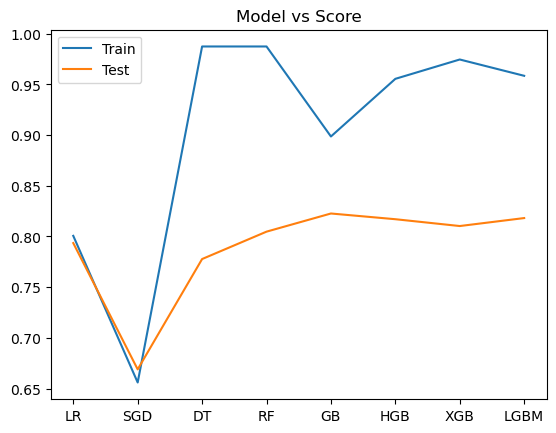

In [275]:
# check model accuracy
print(model_score)
plt.plot(model_score['model'], model_score['Train'])
plt.plot(model_score['model'], model_score['Test'])
plt.legend(['Train', 'Test'])
plt.title('Model vs Score')
plt.show()

# 5. Model Tuning - LGBM

In [276]:
from sklearn.model_selection import train_test_split
from lightgbm import early_stopping, log_evaluation

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

lgbm = LGBMClassifier(random_state=0, force_col_wise=True, n_estimators=400)

lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='logloss',
    callbacks=[early_stopping(stopping_rounds=100), log_evaluation(50)]
)

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

LGBMClassifier(force_col_wise=True, n_estimators=400, random_state=0)

# 6. Submission

In [277]:
y_pred = lgbm.predict(X_pred)
df_sub['Survived'] = y_pred
df_sub.to_csv(save_path, index=False)